In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

In [3]:
batch_size=64
img_size=28
RNN_unit=img_size*img_size
N_watch=10

In [4]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,img_size*img_size])
y=tf.placeholder(dtype=tf.int64,shape=[None,10])

predict_net=tf.layers.Dense(units=10)

def get_next_input(output, i):
    attention_weight=tf.nn.softmax(output)
    weighted_graph=X*attention_weight
    return weighted_graph

lstm_cell = tf.nn.rnn_cell.LSTMCell(RNN_unit, state_is_tuple=True)
init_state = lstm_cell.zero_state(batch_size, tf.float32)

inputs=[X]
inputs.extend([0]*N_watch)
outputs,_ = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, init_state, lstm_cell, loop_function=get_next_input)

output=outputs[-1]
score=predict_net(output)

predictions = tf.argmax(score, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

loss=tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score)
optimizier=tf.train.AdamOptimizer(learning_rate=1e-5)
train_step = optimizier.minimize(loss)

In [5]:
max_epoch=100
print_every=200

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        loss_num,_ = sess.run([loss,train_step],feed_dict={X:images,y:labels})
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f' % (loss_num))
            
def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images,y:labels})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy

In [6]:
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]

saver = tf.train.Saver()
    
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    max_acc=None
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d:' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,500)
        loss_val,acc_val=eval(mnist.validation,70)
        loss_test,acc_test=eval(mnist.test,150)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        
        if max_acc==None or acc_val>max_acc:
            max_acc=acc_val
            save_path = saver.save(sess, "model/SRAM/SRAM.ckpt")
            print("Currently maximum accuracy on validation set, model saved in path: %s" % save_path)
        
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-17 12:49:45 start epoch 1/100:
2018-04-17 12:49:45 iteration 1/859: current training loss = 2.302674
2018-04-17 12:49:47 iteration 200/859: current training loss = 2.033743
2018-04-17 12:49:49 iteration 400/859: current training loss = 0.936832
2018-04-17 12:49:51 iteration 600/859: current training loss = 0.495727
2018-04-17 12:49:53 iteration 800/859: current training loss = 0.456990
2018-04-17 12:49:54 iteration 859/859: current training loss = 0.519808
Currently maximum accuracy on validation set, model saved in path: model/SRAM/SRAM.ckpt
2018-04-17 12:50:10 end epoch 1/100: acc_train=85.602% acc_val=86.269% acc_test=85.817%
2018-04-17 12:50:10 start epoch 2/100:
2018-04-17 12:50:10 iteration 1/859: current training loss = 0.394443
2018-04-17 12:50:12 iteration 200/859: current training loss = 0.515124
2018-04-17 12:50:14 iteration 400/859: current training loss = 0.273336
2018-04-17 12:50:17 iteration 600/859: current training loss = 0.277814
2018-04-17 12:50:19 iteration 

2018-04-17 12:55:21 iteration 200/859: current training loss = 0.131777
2018-04-17 12:55:23 iteration 400/859: current training loss = 0.125124
2018-04-17 12:55:25 iteration 600/859: current training loss = 0.110708
2018-04-17 12:55:29 iteration 800/859: current training loss = 0.094765
2018-04-17 12:55:30 iteration 859/859: current training loss = 0.065174
Currently maximum accuracy on validation set, model saved in path: model/SRAM/SRAM.ckpt
2018-04-17 12:55:47 end epoch 14/100: acc_train=96.537% acc_val=96.072% acc_test=95.875%
2018-04-17 12:55:47 start epoch 15/100:
2018-04-17 12:55:47 iteration 1/859: current training loss = 0.143843
2018-04-17 12:55:49 iteration 200/859: current training loss = 0.131266
2018-04-17 12:55:52 iteration 400/859: current training loss = 0.057898
2018-04-17 12:55:54 iteration 600/859: current training loss = 0.288570
2018-04-17 12:55:56 iteration 800/859: current training loss = 0.109277
2018-04-17 12:55:57 iteration 859/859: current training loss = 0.

2018-04-17 13:00:53 iteration 859/859: current training loss = 0.009471
Currently maximum accuracy on validation set, model saved in path: model/SRAM/SRAM.ckpt
2018-04-17 13:01:08 end epoch 27/100: acc_train=98.263% acc_val=97.128% acc_test=96.933%
2018-04-17 13:01:08 start epoch 28/100:
2018-04-17 13:01:08 iteration 1/859: current training loss = 0.006701
2018-04-17 13:01:11 iteration 200/859: current training loss = 0.013714
2018-04-17 13:01:13 iteration 400/859: current training loss = 0.045426
2018-04-17 13:01:15 iteration 600/859: current training loss = 0.074597
2018-04-17 13:01:16 iteration 800/859: current training loss = 0.077855
2018-04-17 13:01:17 iteration 859/859: current training loss = 0.063901
2018-04-17 13:01:32 end epoch 28/100: acc_train=98.242% acc_val=96.906% acc_test=96.812%
2018-04-17 13:01:32 start epoch 29/100:
2018-04-17 13:01:32 iteration 1/859: current training loss = 0.034085
2018-04-17 13:01:34 iteration 200/859: current training loss = 0.065635
2018-04-17

2018-04-17 13:08:33 iteration 600/859: current training loss = 0.070535
2018-04-17 13:08:35 iteration 800/859: current training loss = 0.005099
2018-04-17 13:08:35 iteration 859/859: current training loss = 0.031220
2018-04-17 13:08:51 end epoch 46/100: acc_train=99.111% acc_val=96.972% acc_test=97.169%
2018-04-17 13:08:51 start epoch 47/100:
2018-04-17 13:08:51 iteration 1/859: current training loss = 0.055605
2018-04-17 13:08:53 iteration 200/859: current training loss = 0.063109
2018-04-17 13:08:55 iteration 400/859: current training loss = 0.050711
2018-04-17 13:08:57 iteration 600/859: current training loss = 0.059239
2018-04-17 13:08:59 iteration 800/859: current training loss = 0.007327
2018-04-17 13:09:01 iteration 859/859: current training loss = 0.003897
2018-04-17 13:09:15 end epoch 47/100: acc_train=99.362% acc_val=97.484% acc_test=97.425%
2018-04-17 13:09:15 start epoch 48/100:
2018-04-17 13:09:15 iteration 1/859: current training loss = 0.009237
2018-04-17 13:09:17 iterat

2018-04-17 13:14:30 iteration 859/859: current training loss = 0.006695
Currently maximum accuracy on validation set, model saved in path: model/SRAM/SRAM.ckpt
2018-04-17 13:14:44 end epoch 60/100: acc_train=99.759% acc_val=97.678% acc_test=97.541%
2018-04-17 13:14:44 start epoch 61/100:
2018-04-17 13:14:44 iteration 1/859: current training loss = 0.006601
2018-04-17 13:14:46 iteration 200/859: current training loss = 0.028407
2018-04-17 13:14:49 iteration 400/859: current training loss = 0.001811
2018-04-17 13:14:51 iteration 600/859: current training loss = 0.011395
2018-04-17 13:14:53 iteration 800/859: current training loss = 0.009340
2018-04-17 13:14:53 iteration 859/859: current training loss = 0.002763
2018-04-17 13:15:07 end epoch 61/100: acc_train=99.686% acc_val=97.494% acc_test=97.458%
2018-04-17 13:15:07 start epoch 62/100:
2018-04-17 13:15:07 iteration 1/859: current training loss = 0.004034
2018-04-17 13:15:11 iteration 200/859: current training loss = 0.007319
2018-04-17

2018-04-17 13:20:21 iteration 400/859: current training loss = 0.000748
2018-04-17 13:20:23 iteration 600/859: current training loss = 0.000500
2018-04-17 13:20:26 iteration 800/859: current training loss = 0.005257
2018-04-17 13:20:27 iteration 859/859: current training loss = 0.003906
2018-04-17 13:20:41 end epoch 75/100: acc_train=99.820% acc_val=97.097% acc_test=97.211%
2018-04-17 13:20:41 start epoch 76/100:
2018-04-17 13:20:41 iteration 1/859: current training loss = 0.027441
2018-04-17 13:20:43 iteration 200/859: current training loss = 0.002817
2018-04-17 13:20:45 iteration 400/859: current training loss = 0.011387
2018-04-17 13:20:48 iteration 600/859: current training loss = 0.001013
2018-04-17 13:20:50 iteration 800/859: current training loss = 0.001913
2018-04-17 13:20:50 iteration 859/859: current training loss = 0.014988
2018-04-17 13:21:09 end epoch 76/100: acc_train=99.913% acc_val=97.525% acc_test=97.503%
2018-04-17 13:21:09 start epoch 77/100:
2018-04-17 13:21:09 iter

2018-04-17 13:26:28 iteration 200/859: current training loss = 0.004679
2018-04-17 13:26:29 iteration 400/859: current training loss = 0.035776
2018-04-17 13:26:31 iteration 600/859: current training loss = 0.006273
2018-04-17 13:26:34 iteration 800/859: current training loss = 0.001328
2018-04-17 13:26:34 iteration 859/859: current training loss = 0.013200
2018-04-17 13:26:48 end epoch 90/100: acc_train=99.888% acc_val=97.466% acc_test=97.320%
2018-04-17 13:26:48 start epoch 91/100:
2018-04-17 13:26:48 iteration 1/859: current training loss = 0.000748
2018-04-17 13:26:50 iteration 200/859: current training loss = 0.004525
2018-04-17 13:26:52 iteration 400/859: current training loss = 0.021099
2018-04-17 13:26:55 iteration 600/859: current training loss = 0.001778
2018-04-17 13:26:57 iteration 800/859: current training loss = 0.001522
2018-04-17 13:26:58 iteration 859/859: current training loss = 0.048503
2018-04-17 13:27:13 end epoch 91/100: acc_train=99.805% acc_val=97.394% acc_test=

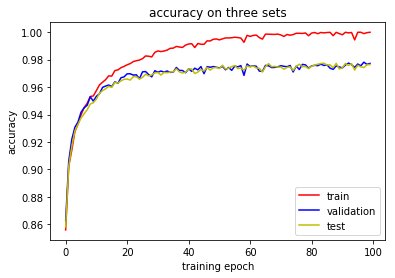

In [7]:
plt.figure(2)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()

In [8]:
saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "model/SRAM/SRAM.ckpt")
    _,acc_train=eval(mnist.train,num_train//batch_size)
    _,acc_val=eval(mnist.validation,num_val//batch_size)
    _,acc_test=eval(mnist.test,num_test//batch_size)
    print('Accuracy on training set is %.3f%%' % (acc_train*100.0))
    print('Accuracy on validation set is %.3f%%' % (acc_val*100.0))
    print('Accuracy on testing set is %.3f%%' % (acc_test*100.0))

INFO:tensorflow:Restoring parameters from model/SRAM/SRAM.ckpt
Accuracy on training set is 99.878%
Accuracy on validation set is 97.796%
Accuracy on testing set is 97.426%
